# Case Study 2

Your case study is to build a classifier using logistic regression to predict hospital readmittance. There is missing data that must be imputed.
Once again, discuss variable importances as part of your submission.

## Data Examination

In [1]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# imblearn libraries
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

# Other libraries
import eli5

In [2]:
# Read in the data
df = pd.read_csv('diabetic_data.csv')
ids = pd.read_csv('IDs_mapping.csv')

In [3]:
ids.head()

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

### Numeric Variables

In [6]:
# Examine the numeric columns
df_numeric = df.select_dtypes(include=[np.number])
df_numeric.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [7]:
# Get numeric column names
for name in df.select_dtypes(include=[np.number]):
    print(name)

encounter_id
patient_nbr
admission_type_id
discharge_disposition_id
admission_source_id
time_in_hospital
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
number_diagnoses


array([[<AxesSubplot:title={'center':'encounter_id'}>,
        <AxesSubplot:title={'center':'patient_nbr'}>,
        <AxesSubplot:title={'center':'admission_type_id'}>,
        <AxesSubplot:title={'center':'discharge_disposition_id'}>],
       [<AxesSubplot:title={'center':'admission_source_id'}>,
        <AxesSubplot:title={'center':'time_in_hospital'}>,
        <AxesSubplot:title={'center':'num_lab_procedures'}>,
        <AxesSubplot:title={'center':'num_procedures'}>],
       [<AxesSubplot:title={'center':'num_medications'}>,
        <AxesSubplot:title={'center':'number_outpatient'}>,
        <AxesSubplot:title={'center':'number_emergency'}>,
        <AxesSubplot:title={'center':'number_inpatient'}>],
       [<AxesSubplot:title={'center':'number_diagnoses'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

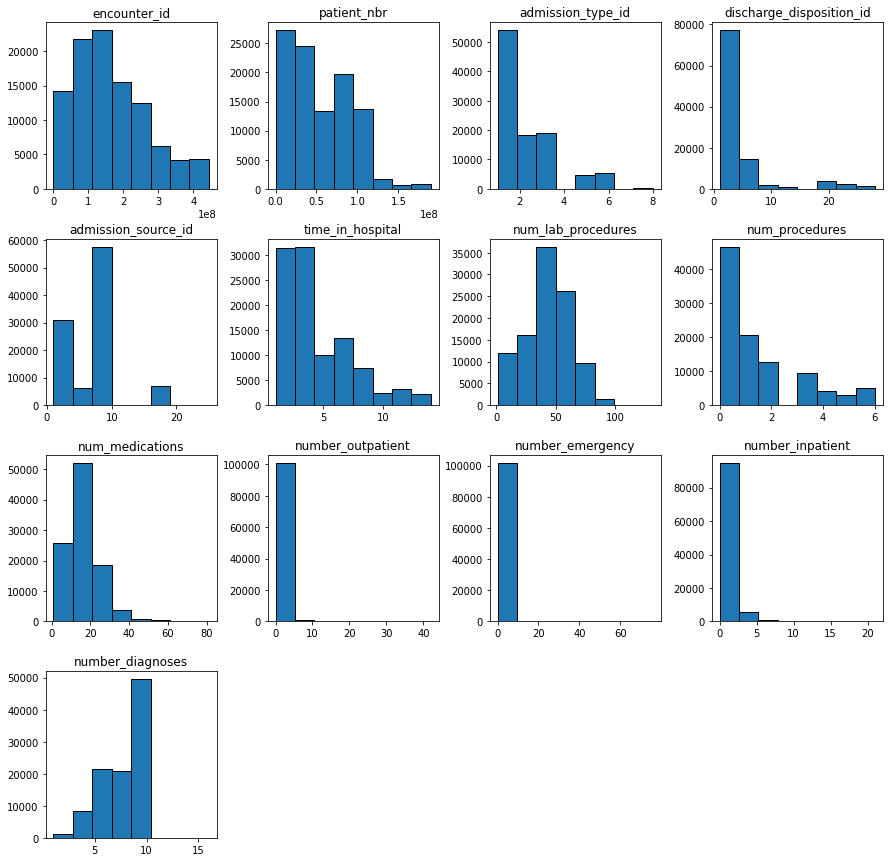

In [8]:
df.hist(figsize=(15,15), edgecolor="black", bins=8, grid=False)

### Character Variables

In [9]:
# Examine the numeric columns
df_character = df.select_dtypes(include=object)
df_character.describe()

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,6,3,10,10,18,73,717,749,790,4,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),?,?,?,428,276,250,None,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,98569,40256,49949,6862,6752,11555,96420,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


In [10]:
# Get character column names
for name in df.select_dtypes(include=object):
    print(name)

race
gender
age
weight
payer_code
medical_specialty
diag_1
diag_2
diag_3
max_glu_serum
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
examide
citoglipton
insulin
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
change
diabetesMed
readmitted


## Examine Missing Data

In [11]:
%%capture --no-display

df_missing = pd.DataFrame()

for col in df.columns:
    df_missing = df_missing.append({"Column Name": col,
                                    "# Missing":len(df[df[col] == '?']),
                                    "% Missing":len(df[df[col] == '?'])/len(df)*100 },
                                   ignore_index=True)   
df_missing["% Missing"] = df_missing["% Missing"].round(decimals = 3)
df_missing[df_missing["% Missing"] > 0]

,Column Name,# Missing,% Missing
2,race,2273,2.234
5,weight,98569,96.858
10,payer_code,40256,39.557
11,medical_specialty,49949,49.082
18,diag_1,21,0.021
19,diag_2,358,0.352
20,diag_3,1423,1.398


## Data Plan

1. Remove weight - almost 97% missing.
2. Remove `examide` & `citoglipton` since they each only have 1 value.
3. Remove ID columns `encounter_id` and `patient_nbr` that don't assist with analysis.
4. Remove `payer_code` and `medical_specialty`. It may be possible to impute these, but with so much of the data missing I'd like to see how the analysis performs without it.

## Drop Columns

In [12]:
df_clean = df.drop(columns=['weight',
                            'examide',
                            'citoglipton',
                            'encounter_id',
                            'patient_nbr',
                            'payer_code',
                            'medical_specialty'
                           ]
                  )

In [13]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  int64 
 4   discharge_disposition_id  101766 non-null  int64 
 5   admission_source_id       101766 non-null  int64 
 6   time_in_hospital          101766 non-null  int64 
 7   num_lab_procedures        101766 non-null  int64 
 8   num_procedures            101766 non-null  int64 
 9   num_medications           101766 non-null  int64 
 10  number_outpatient         101766 non-null  int64 
 11  number_emergency          101766 non-null  int64 
 12  number_inpatient          101766 non-null  int64 
 13  diag_1                    101766 non-null  object
 14  diag

## Categorize Diagnoses

Based on previous research found [here](https://www.hindawi.com/journals/bmri/2014/781670/tab2/).

In [14]:
def categorize_diagnosis(icd9_code):
    
    try:
        icd9_code = float(icd9_code)
    except:
        icd9_code = 0

    # Circulatory
    if icd9_code in range(390, 460) or icd9_code == 785:
        return("Circulatory")

    # Respiratory
    elif icd9_code in range(460, 520) or icd9_code == 786:
        return("Respiratory")

    # Digestive
    elif icd9_code in range(520, 580) or icd9_code == 787:
        return("Digestive")

    # Diabetes
    # elif icd9_code.between(250, 251):  # 'float' object has no attribute 'between' 
    #    return("Diabetes")
    elif icd9_code >= 250 and icd9_code < 251:
        return("Diabetes")

    # Injury
    elif icd9_code in range(800, 1000):
        return("Injury")

    # Musculoskeletal
    elif icd9_code in range(710, 740):
        return("Musculoskeletal")

    # Genitourinary
    elif icd9_code in range(580, 630) or icd9_code == 788:
        return("Genitourinary")

    # Neoplasms
    elif icd9_code in range(1, 250):
        return("Neoplasms")
    
    elif icd9_code in range(251, 320):
        return("Neoplasms")
    
    elif icd9_code in range(680, 710):
        return("Neoplasms")
    
    elif icd9_code in range(780, 783) or icd9_code == 784:
        return("Neoplasms")
    
    elif icd9_code in range(790, 800):
        return("Neoplasms")

    # Other
    else:
        return("Other")

In [15]:
df_clean["Diag1"] = df_clean["diag_1"].apply(categorize_diagnosis)
df_clean["Diag2"] = df_clean["diag_2"].apply(categorize_diagnosis)
df_clean["Diag3"] = df_clean["diag_3"].apply(categorize_diagnosis)


print(df_clean["Diag1"].value_counts())
print("")
print(df_clean["Diag2"].value_counts())
print("")
print(df_clean["Diag3"].value_counts())

Circulatory        30437
Neoplasms          17421
Respiratory        14423
Digestive           9475
Diabetes            8757
Injury              6974
Genitourinary       5117
Musculoskeletal     4957
Other               4205
Name: Diag1, dtype: int64

Circulatory        31881
Neoplasms          24388
Diabetes           12794
Respiratory        10895
Genitourinary       8376
Other               5070
Digestive           4170
Injury              2428
Musculoskeletal     1764
Name: Diag2, dtype: int64

Circulatory        30306
Neoplasms          23475
Diabetes           17157
Other               8999
Respiratory         7358
Genitourinary       6680
Digestive           3930
Injury              1946
Musculoskeletal     1915
Name: Diag3, dtype: int64


In [16]:
# Drop original diag_ columns
df_clean = df_clean.drop(columns=['diag_1', 'diag_2', 'diag_3'])

## Admission Type & Source 

Based on the supplementary material, several admission types and sources look like they could be binned together. [reference](https://www.adamsmith.haus/python/answers/how-to-replace-column-values-in-a-pandas-dataframe-in-python)

In [17]:
df_clean["admission_type_id"].replace({5: 6, 8: 6}, inplace=True)
df_clean.admission_type_id = df_clean.admission_type_id.astype(str)

df_clean["admission_source_id"].replace({9:  17, 
                                15: 17,
                                20: 17,
                                21: 17
                               }, inplace=True)
df_clean.admission_source_id = df_clean.admission_source_id.astype(str)

## Discharge Disposition

Included in the data set are codes that define how the patient was discharged. We can remove those that passed away or went to hospice.

In [18]:
index_names = df_clean[df_clean['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21])].index
df_clean.drop(index_names, inplace=True)

## Response Variable

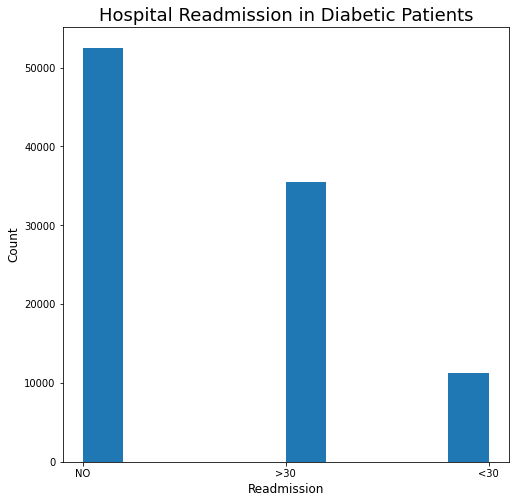

In [19]:
plt.figure(figsize=(8, 8))
plt.hist(df_clean['readmitted'])
plt.xlabel("Readmission", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Hospital Readmission in Diabetic Patients", fontsize=18)
plt.show()

Rather than trying to run a multinomial logistic regression, I'm going to combine 'NO' and '>30' into a single value. I'll also set the response to be a binary value of 1 (readmitted within 1 month) or 0 (readmitted more than 1 month after service or never readmitted).

In [20]:
df_clean["readmitted"].replace({'NO': 0, '>30': 0, '<30': 1}, inplace=True)

In [21]:
df_clean.readmitted.unique()

array([0, 1])

In [22]:
# Get numeric column names
for name in df_clean.select_dtypes(include=[np.number]):
    print(name)

discharge_disposition_id
time_in_hospital
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
number_diagnoses
readmitted


In [23]:
numeric_features = [
    'discharge_disposition_id',
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses'
]

In [24]:
# Get categorical column names
for name in df_clean.select_dtypes(include=object):
    print(name)

race
gender
age
admission_type_id
admission_source_id
max_glu_serum
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
insulin
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
change
diabetesMed
Diag1
Diag2
Diag3


In [25]:
categorical_features = [
    'race',
    'gender',
    'age',
    'admission_type_id',
    'admission_source_id',
    'max_glu_serum',
    'A1Cresult',
    'metformin',
    'repaglinide',
    'nateglinide',
    'chlorpropamide',
    'glimepiride',
    'acetohexamide',
    'glipizide',
    'glyburide',
    'tolbutamide',
    'pioglitazone',
    'rosiglitazone',
    'acarbose',
    'miglitol',
    'troglitazone',
    'tolazamide',
    'insulin',
    'glyburide-metformin',
    'glipizide-metformin',
    'glimepiride-pioglitazone',
    'metformin-rosiglitazone',
    'metformin-pioglitazone',
    'change',
    'diabetesMed',
    'Diag1',
    'Diag2',
    'Diag3'
]

In [26]:
# Define response & feature variables
X = df_clean.drop(labels = ['readmitted'], axis = 1) 
y = df_clean['readmitted']

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99343 entries, 0 to 101765
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      99343 non-null  object
 1   gender                    99343 non-null  object
 2   age                       99343 non-null  object
 3   admission_type_id         99343 non-null  object
 4   discharge_disposition_id  99343 non-null  int64 
 5   admission_source_id       99343 non-null  object
 6   time_in_hospital          99343 non-null  int64 
 7   num_lab_procedures        99343 non-null  int64 
 8   num_procedures            99343 non-null  int64 
 9   num_medications           99343 non-null  int64 
 10  number_outpatient         99343 non-null  int64 
 11  number_emergency          99343 non-null  int64 
 12  number_inpatient          99343 non-null  int64 
 13  number_diagnoses          99343 non-null  int64 
 14  max_glu_serum        

In [28]:
# Split into test/train
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=123)

In [29]:
pipeline_numeric = Pipeline(steps=[
    
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', RobustScaler(with_centering=False))

])

pipeline_categorical = Pipeline(steps=[
    
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))

])

preprocessor = ColumnTransformer(
    transformers=[
        
        ('num', pipeline_numeric, numeric_features),
        ('cat', pipeline_categorical, categorical_features)
    
    ])

In [30]:
# Set up pipeline
pipeline = imbpipeline(steps = [['preprocessor', preprocessor],
                                 ['smote', SMOTE(random_state=123)],
                                 ['classifier', LogisticRegression(random_state=123,
                                                                   max_iter=1000, 
                                                                   n_jobs=-1)]])

In [31]:
# Set up cross validation splits
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=123)

## Grid Search

In [32]:
param_grid = [
    {'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'classifier__penalty': ['l1'],
     'classifier__solver': ['saga']
    },
    {'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'classifier__penalty': ['l2'],
     'classifier__solver': ['lbfgs']}
]

In [33]:
grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           n_jobs = -1)

In [34]:
grid_search.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/s

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[['preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          RobustScaler(with_centering=False))]),
                                                                         ['discharge_disposition_id',
                                                                          'time_in_hospital',
                                                                          'num_lab_procedures',
                                                                          'num_procedures',
                                                                          '...
                                       ['classifier',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=-1,
                                                           random_state=123)]]),
             n_jobs=-1,
             param_grid=[{'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                            100, 1000],
                          'classifier__penalty': ['l1'],
                          'classifier__solver': ['saga']},
                         {'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                            100, 1000],
                          'classifier__penalty': ['l2'],
                          'classifier__solver': ['lbfgs']}],
             scoring='roc_auc')

In [35]:
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.6446826623915306
Test score: 0.6485174878400383


## Best Estimator

In [36]:
lr_results = pd.DataFrame(grid_search.cv_results_['params'])
lr_results['test_score'] = grid_search.cv_results_['mean_test_score']
lr_results 

,classifier__C,classifier__penalty,classifier__solver,test_score
0,0.0001,l1,saga,0.625396
1,0.0010,l1,saga,0.640307
2,0.0100,l1,saga,0.635840
3,0.1000,l1,saga,0.629822
4,1.0000,l1,saga,0.628586
5,10.0000,l1,saga,0.628413
6,100.0000,l1,saga,0.628395
7,1000.0000,l1,saga,0.628393
8,0.0001,l2,lbfgs,0.644683
9,0.0010,l2,lbfgs,0.636427


In [37]:
print(grid_search.best_params_)

{'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


## Feature Importance

In [38]:
onehot_columns = list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)

eli5.explain_weights(grid_search.best_estimator_.named_steps['classifier'], top=10, feature_names=numeric_features_list)

Explanation(estimator='LogisticRegression(C=0.0001, max_iter=1000, n_jobs=-1, random_state=123)', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='number_inpatient', weight=0.23538535924198128, std=None, value=None), FeatureWeight(feature='number_diagnoses', weight=0.1266738049640286, std=None, value=None), FeatureWeight(feature='A1Cresult_None', weight=0.09329335949377346, std=None, value=None), FeatureWeight(feature='Diag1_Circulatory', weight=0.08027575979093611, std=None, value=None), FeatureWeight(feature='race_Caucasian', weight=0.0768760984671327, std=None, value=None), FeatureWeight(feature='discharge_disposition_id', weight=0.05988286189607563, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-1.195192508095825, std=None, value=None), FeatureWeight(feature='insulin_No', weight=-0.07869970442868049, std=None, value=None), FeatureWeight(feature='age_[50-60)', weight=-0.05909122390789809, std=None, value=None), FeatureWeight(feature='num_procedures', weight=-0.055637341462766894, std=None, value=None)], pos_remaining=53, neg_remaining=94), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

## Model Evaluation

(0.0, 1.0)

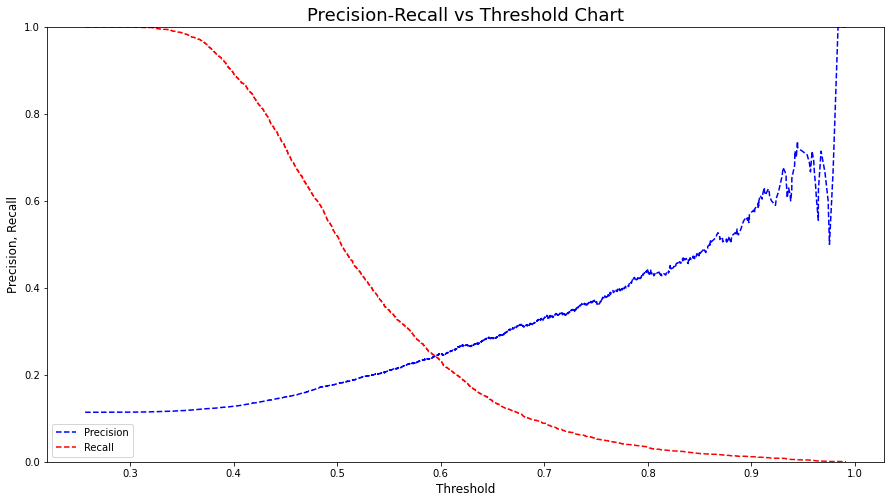

In [39]:
probs_y = grid_search.predict_proba(X_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, probs_y[:,1]) 

plt.figure(figsize=(15, 8))

plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")

plt.title("Precision-Recall vs Threshold Chart", fontsize = 18)
plt.ylabel("Precision, Recall", fontsize = 12)
plt.xlabel("Threshold", fontsize = 12)

plt.legend(loc="lower left")

plt.ylim([0,1])